### Install

In [ ]:
pip install tensorflow matplotlib numpy

In [21]:
import timm

### Import Libery

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score
import copy
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import timm

### GPU Check

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda


### Data Transform

In [6]:
IMAGE_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Create Data

In [7]:
dataset_path = "/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset"
def pil_loader_rgb(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')  # แปลงภาพให้เป็น RGB

dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform, loader=pil_loader_rgb)

In [8]:
print("Total image", len(dataset))
print("Class name", dataset.classes)

Total image 5418
Class name ['Female Faces', 'Male Faces']


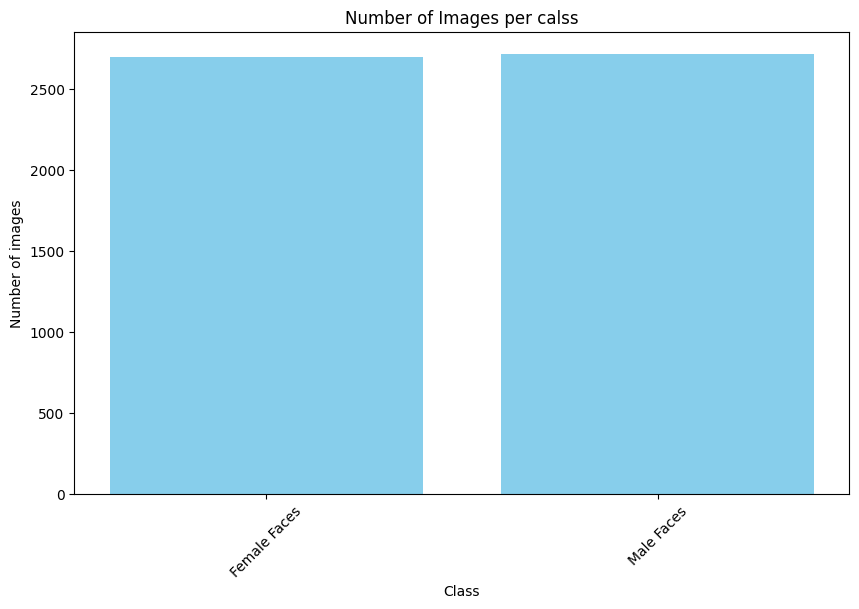

In [13]:
class_indices = [s[1] for s in dataset.samples]

counts = Counter(class_indices)

class_counts = [counts[i] for i in range(len(dataset.classes))]

plt.figure(figsize=(10,6))
plt.bar(dataset.classes, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of Images per calss')
plt.xticks(rotation=45)
plt.show()

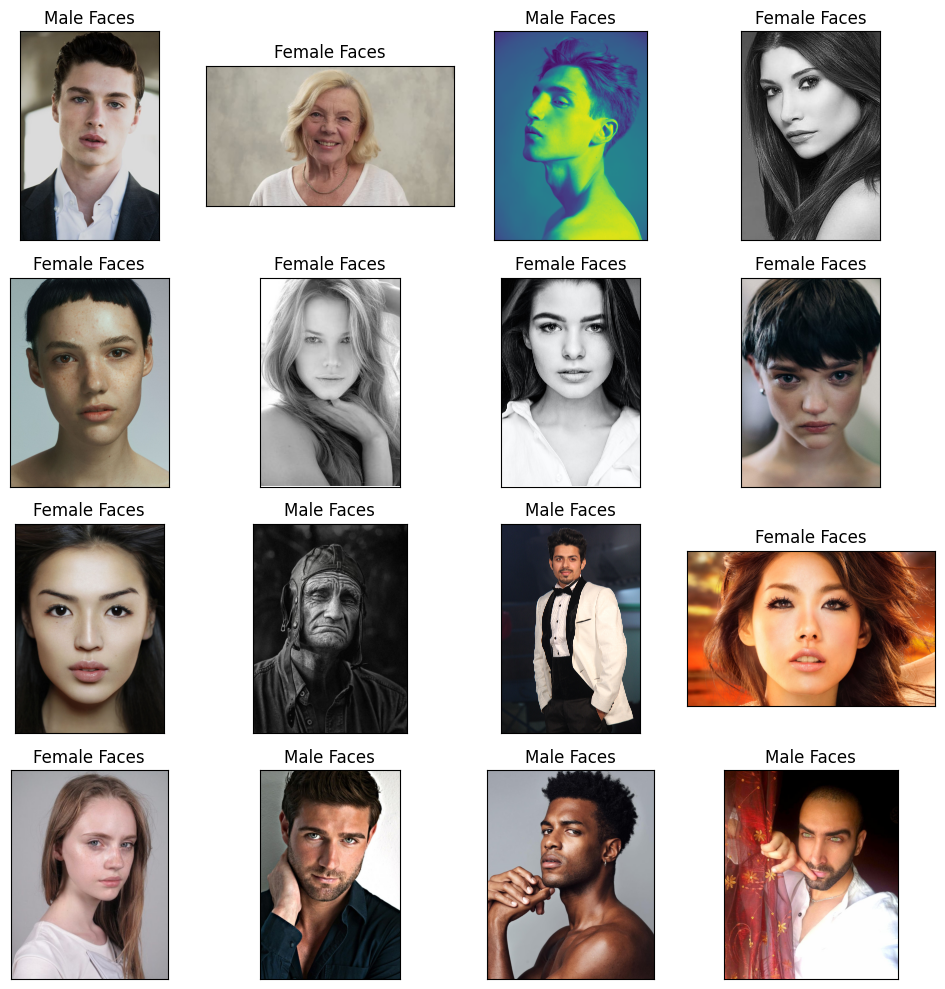

In [16]:
random_index = np.random.randint(0, len(dataset), 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    filepath, label_idx = dataset.samples[random_index[i]]
    image = plt.imread(filepath)
    ax.imshow(image)
    ax.set_title(dataset.classes[label_idx])

plt.tight_layout()
plt.show()                         

### Split Data

In [17]:
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print("Train dataset size", len(train_dataset))
print("Val dataset size", len(val_dataset))

Train dataset size 4334
Val dataset size 1084


### Create DataLoader

In [19]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

### Crate Model

In [23]:
model_name = "efficientnet_b0"
model = timm.create_model(model_name, pretrained=True, num_classes=2)
model.to(device)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

### Lost Function

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True)

patience = 3
patience_counter = 0
best_val_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, train_accs = [], []
val_losses, val_accs, val_f1s = [], [], []

### Train One Epoch Function

In [30]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

### Evaluate Function (Loss, Accuracy and F1 Score)

In [31]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, epoch_acc, epoch_f1

### Model Train

In [32]:
NUM_EPOCHS = 30


for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    scheduler.step(val_f1)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_efficientnet.pth")
        print("  Best model saved.")
        patience_counter = 0  # reset counter
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

model.load_state_dict(best_model_wts)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/30]
  Train Loss: 0.4318 | Train Acc: 91.74%
  Val Loss: 0.0659 | Val Acc: 97.88% | Val F1: 0.9788
  Best model saved.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/30]
  Train Loss: 0.0648 | Train Acc: 97.97%
  Val Loss: 0.0313 | Val Acc: 98.80% | Val F1: 0.9880
  Best model saved.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/30]
  Train Loss: 0.0681 | Train Acc: 97.78%
  Val Loss: 0.0979 | Val Acc: 97.32% | Val F1: 0.9732


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/30]
  Train Loss: 0.0495 | Train Acc: 98.25%
  Val Loss: 0.0365 | Val Acc: 98.99% | Val F1: 0.9899
  Best model saved.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/30]
  Train Loss: 0.0207 | Train Acc: 99.28%
  Val Loss: 0.0420 | Val Acc: 98.25% | Val F1: 0.9825


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/30]
  Train Loss: 0.0537 | Train Acc: 98.43%
  Val Loss: 0.0303 | Val Acc: 98.80% | Val F1: 0.9880


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/30]
  Train Loss: 0.0325 | Train Acc: 99.01%
  Val Loss: 0.0525 | Val Acc: 98.25% | Val F1: 0.9825
Early stopping triggered.


<All keys matched successfully>

In [33]:
torch.save(model.state_dict(), "best_efficientnet_model.pth")

### Graph

In [34]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(18,5))

<Figure size 1800x500 with 0 Axes>

<Figure size 1800x500 with 0 Axes>

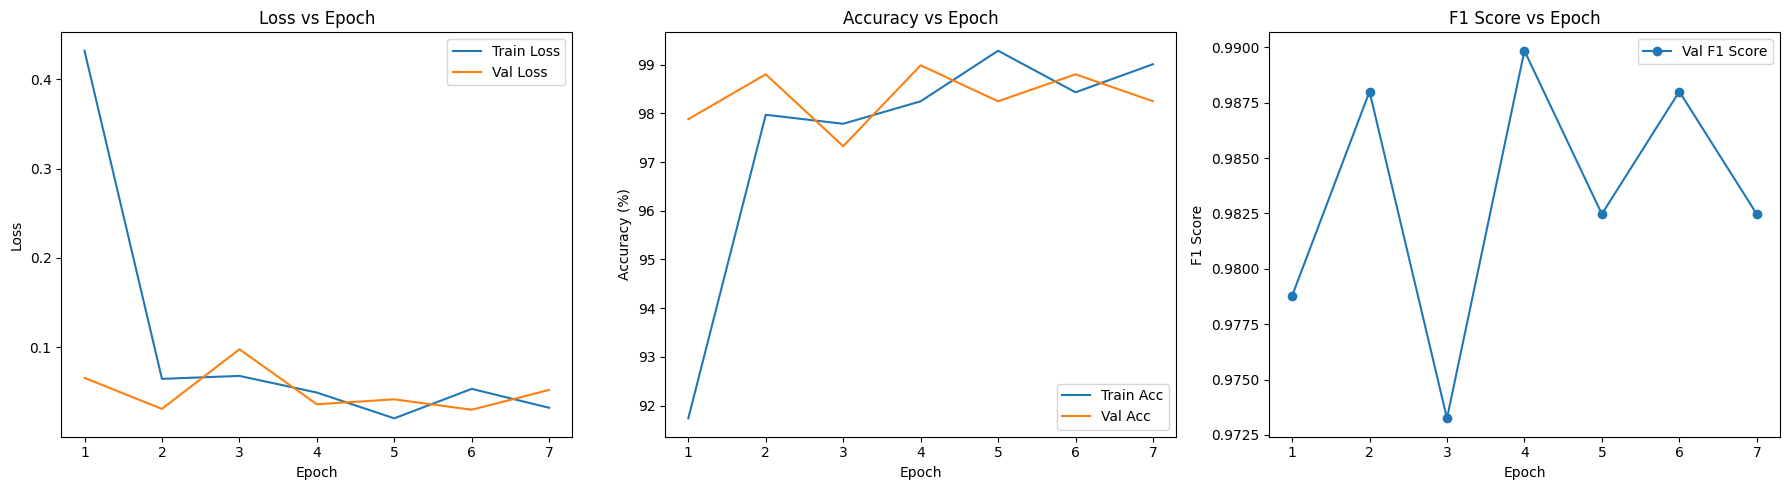

In [37]:
plt.figure(figsize=(18, 5))  # ปรับความกว้างเป็น 18 หน่วย และความสูง 5 หน่วย

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_f1s, label="Val F1 Score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


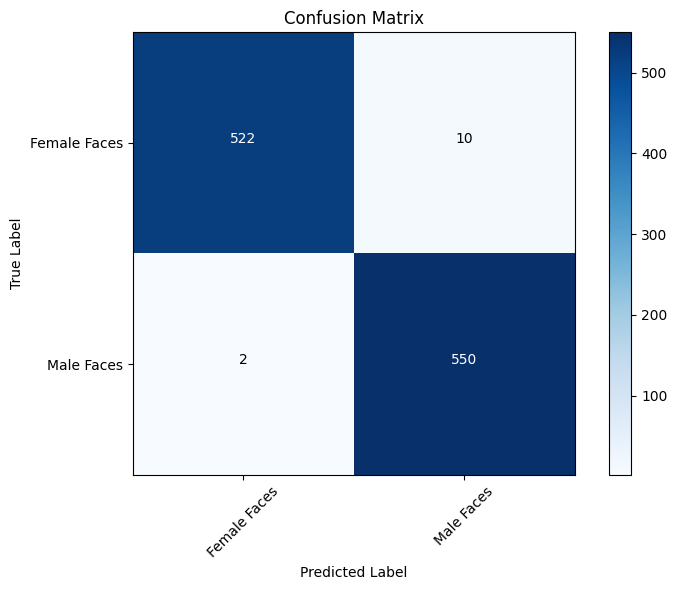

In [38]:
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# classes = train_dataset.classes
classes = dataset.classes

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Predicted Validation

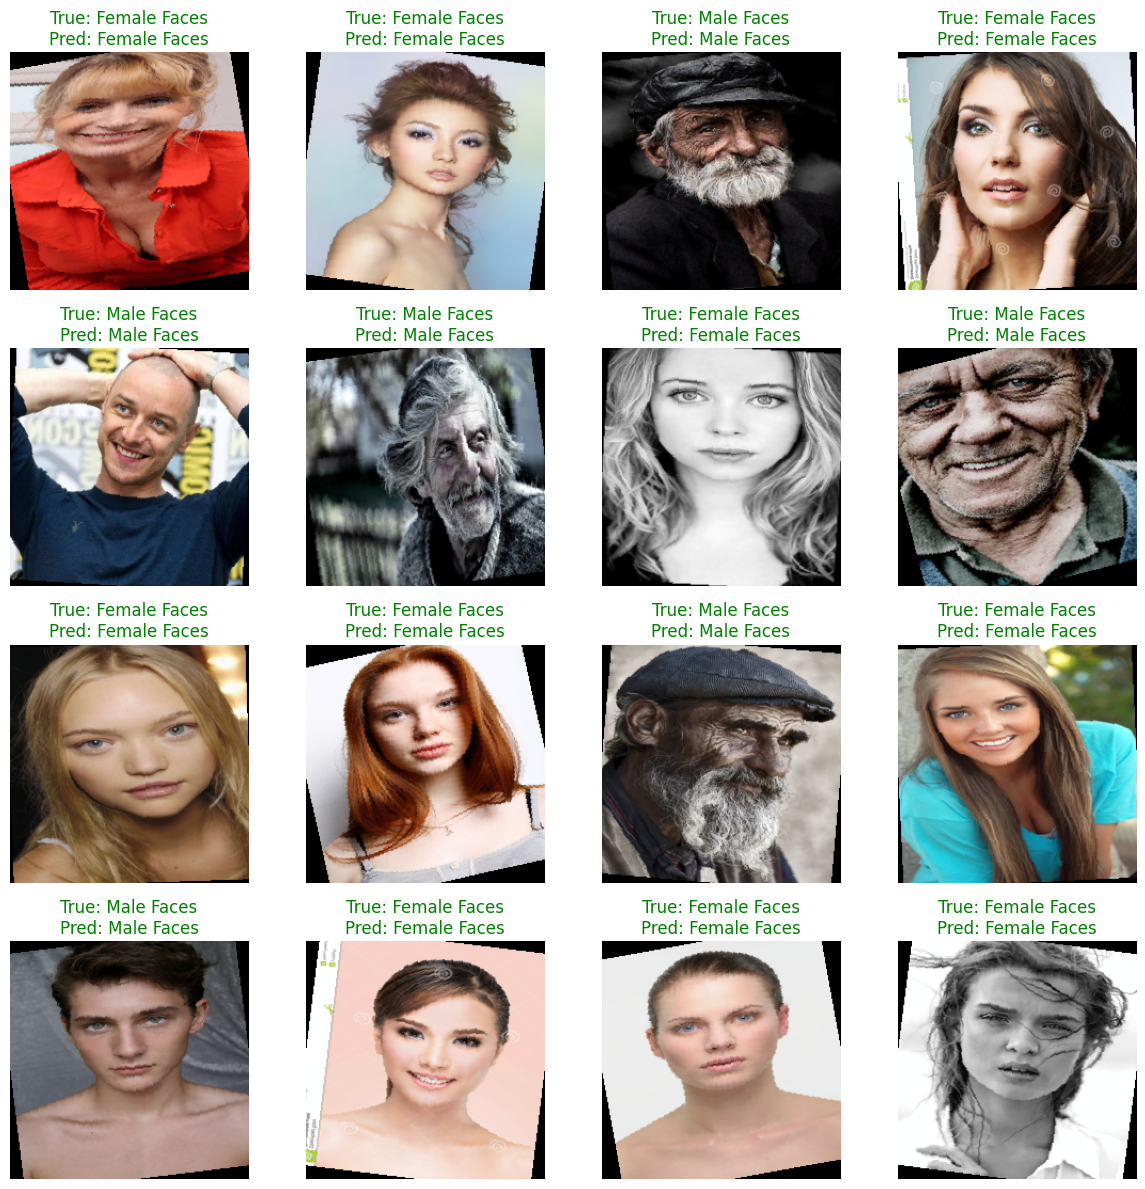

In [41]:
num_samples = 16
indices = np.random.choice(len(val_dataset), size=num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, idx in enumerate(indices):
    image, label = val_dataset[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    outputs = model(image_tensor)
    _, pred = torch.max(outputs, 1)
    pred = pred.item()
    
    # Inverse normalization
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    ax = axes.flat[i]
    ax.imshow(image_np)
    
    color = 'green' if pred == label else 'red'
    
    # true_label = val_dataset.classes[label]
    # pred_label = val_dataset.classes[pred]
    true_label = dataset.classes[label]
    pred_label = dataset.classes[pred]
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()